# Evironment initialization

In [1]:
source("./initialization.r")

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: DT
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: magick
Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11
Loading required package: cowplot

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading re

# Data inspection

In [2]:
bugsData <- read.table("bugs.csv", header=TRUE, sep=";", stringsAsFactors=FALSE)

In [3]:
classes <- sapply(bugsData, class)
classes
dim(bugsData)
dim(na.omit(bugsData))

CBO                 DIT               FanIn              FanOut 
          "integer"           "integer"           "integer"           "integer" 
               LCOM                 NOC                 RFC                 WMC 
          "integer"           "integer"           "integer"           "integer" 
                LOC          Attributes AttributesInherited             Methods 
          "integer"           "integer"           "integer"           "integer" 
   MethodsInherited                Bugs 
          "integer"           "integer"

[1] 997  14

[1] 997  14

In [4]:
summary(bugsData)

      CBO              DIT            FanIn             FanOut      
 Min.   :  0.00   Min.   :1.000   Min.   :  0.000   Min.   : 0.000  
 1st Qu.:  3.00   1st Qu.:1.000   1st Qu.:  1.000   1st Qu.: 2.000  
 Median :  7.00   Median :2.000   Median :  2.000   Median : 4.000  
 Mean   : 12.22   Mean   :2.727   Mean   :  5.368   Mean   : 7.395  
 3rd Qu.: 14.00   3rd Qu.:4.000   3rd Qu.:  4.000   3rd Qu.:10.000  
 Max.   :156.00   Max.   :8.000   Max.   :137.000   Max.   :93.000  
      LCOM              NOC               RFC               WMC         
 Min.   :    0.0   Min.   : 0.0000   Min.   :   0.00   Min.   :   0.00  
 1st Qu.:    6.0   1st Qu.: 0.0000   1st Qu.:  12.00   1st Qu.:   8.00  
 Median :   28.0   Median : 0.0000   Median :  30.00   Median :  20.00  
 Mean   :  364.7   Mean   : 0.7121   Mean   :  76.87   Mean   :  58.38  
 3rd Qu.:   91.0   3rd Qu.: 0.0000   3rd Qu.:  70.00   3rd Qu.:  50.00  
 Max.   :81003.0   Max.   :26.0000   Max.   :2603.00   Max.   :1680.00  
      

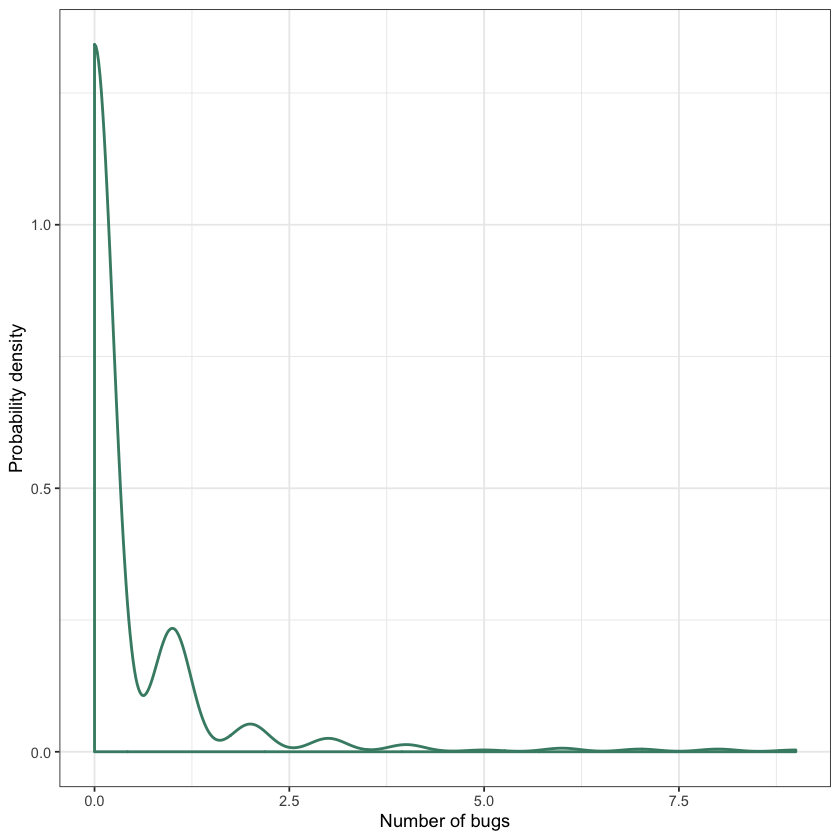

In [5]:
 ggplot(data=bugsData, aes(x=Bugs)) +
  geom_density(color = "aquamarine4", lwd = 0.8) +
  labs(x = "Number of bugs", y = "Probability density") +
  theme_bw()

# Statistical analysis
Correletion "matrix"

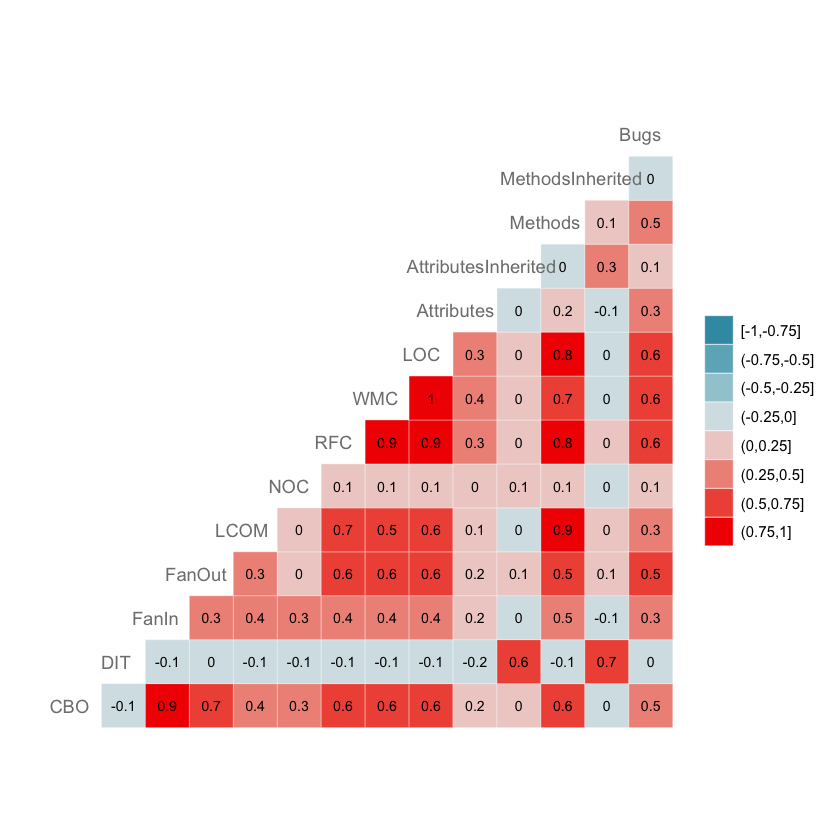

In [6]:
ggcorr(
    bugsData,
    nbreaks = 8,
    label = TRUE,
    label_size = 3,
    color = "grey50",
    layout.exp = 1,
    hjust = 0.75,
    method=c("pairwise", "pearson")
)

## Data distribution plotted
Don't know how to interpret this...

In [7]:
numericChart <- function(colName, colorCol) {
  ggplot(bugsData, aes(x = Bugs, y = bugsData[[colName]])) +
    geom_jitter(size = 1.5, stat = "identity", colour=colorCol) +
    labs(x = "Bugs", y = colName) +
    theme_bw()
}

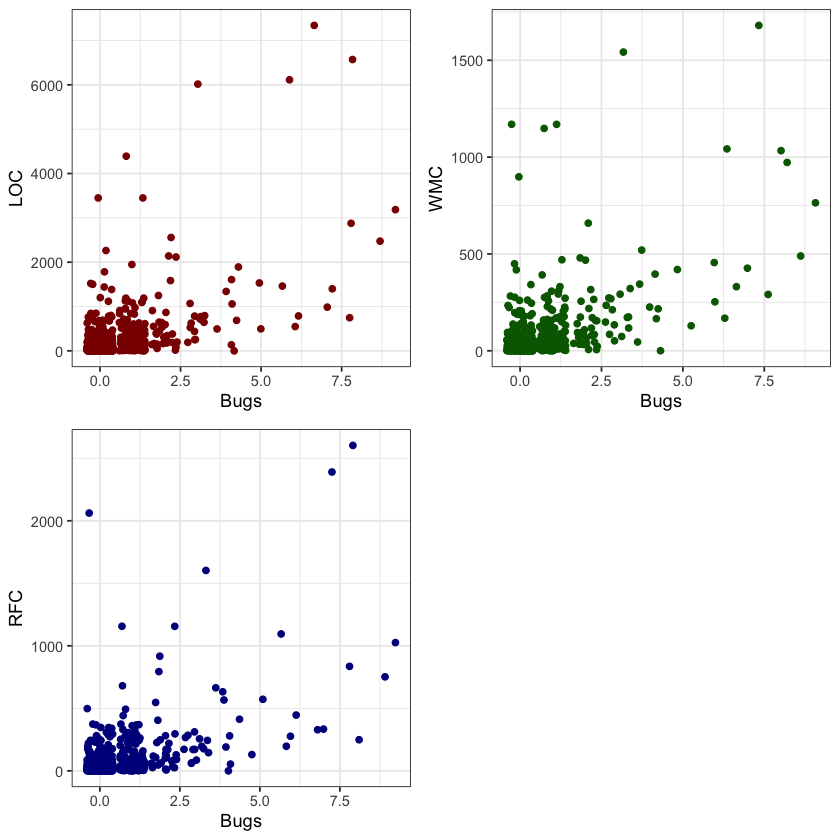

In [8]:
plot_grid(
  numericChart("LOC", "darkred"),
  numericChart("WMC", "darkgreen"),
  numericChart("RFC", "darkblue")
)

# Prepare prediction environment

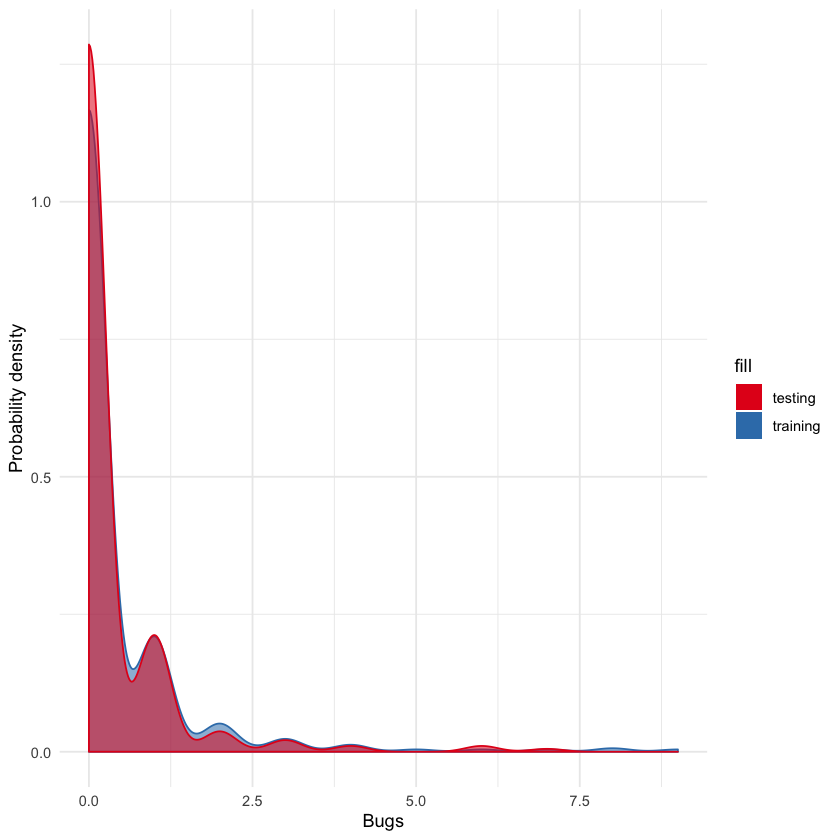

In [9]:
inTrain <- createDataPartition(bugsData$Bugs, p=0.7, list=FALSE)
training <- bugsData[inTrain,]
testing <- bugsData[-inTrain,]

ggplot(mapping=aes(alpha=0.2)) + 
 geom_density(aes(Bugs, fill="training", color="training"), training) + 
 geom_density(aes(Bugs, fill="testing", color="testing"), testing) + 
 theme_minimal() +
  xlab("Bugs") +
  ylab("Probability density") +
  scale_fill_brewer(palette="Set1") +
  scale_color_brewer(palette="Set1") + 
  guides(color = FALSE, alpha = FALSE, fill=guide_legend(override.aes = list(color = NA)))

In [10]:
X_train = select(training, -Bugs)
y_train = training$Bugs
X_test = select(testing, -Bugs)
y_test = testing$Bugs

In [11]:
trcontrol = trainControl(
  method = "cv",
  number = 10,  
  allowParallel = TRUE,
  verboseIter = FALSE,
  returnData = FALSE
)

In [12]:
evaluateStats <- function(model) {
  predicted = predict(model, X_test)
  residuals = y_test - predicted
  
  RMSE <- round(sqrt(mean(residuals^2)), 3)
  
  y_testMean = mean(y_test)
  totalSS =  sum((y_test - y_testMean)^2 )
  residualSS =  sum(residuals^2)
  rSquare  =  round(1 - (residualSS/totalSS), 3)
  
  list(RMSE = RMSE, rSquare = rSquare)
}

In [13]:
predictionChart <- function(model) {
  predicted = predict(model, X_test)
  mergedResults = as.data.frame(cbind(predicted = predicted, observed = y_test))
  # Plot predictions vs test data
  ggplot(mergedResults, aes(y = predicted, x = observed)) +
    geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm) +
    ylab("Predicted number of bugs") +
    xlab("Real number of bugs") + 
    theme(
      axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
      axis.title.x = element_text(size=14), axis.title.y = element_text(size=14)
    )
}

In [14]:
importancePlot <- function(model) ggplot(varImp(model))

# kNN without Preprocessing

In [15]:
knnGrid <- expand.grid(k = seq(1, 25, by = 2))

In [16]:
knnModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid
)

In [17]:
knnModel

k-Nearest Neighbors 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 629, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  0.9601611  0.3150079  0.3931884
   3  0.8829554  0.3604143  0.3837819
   5  0.8795946  0.3759584  0.3988875
   7  0.8793489  0.3814459  0.4014947
   9  0.8783016  0.3792925  0.4049413
  11  0.8631682  0.3923290  0.4029466
  13  0.8624331  0.3964993  0.4049752
  15  0.8643656  0.3905176  0.4042965
  17  0.8566519  0.4009172  0.4010665
  19  0.8588850  0.3986943  0.4007061
  21  0.8576121  0.4076358  0.3990857
  23  0.8658259  0.3971095  0.4027625
  25  0.8704266  0.3921622  0.4056561

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 17.

In [18]:
knnModel$bestTune
knnStats <- evaluateStats(knnModel)
knnStats

,k
,<dbl>
9,17


$RMSE
[1] 0.726

$rSquare
[1] 0.31

##### knnStats <- evaluateStats(knnModel)
knnStats

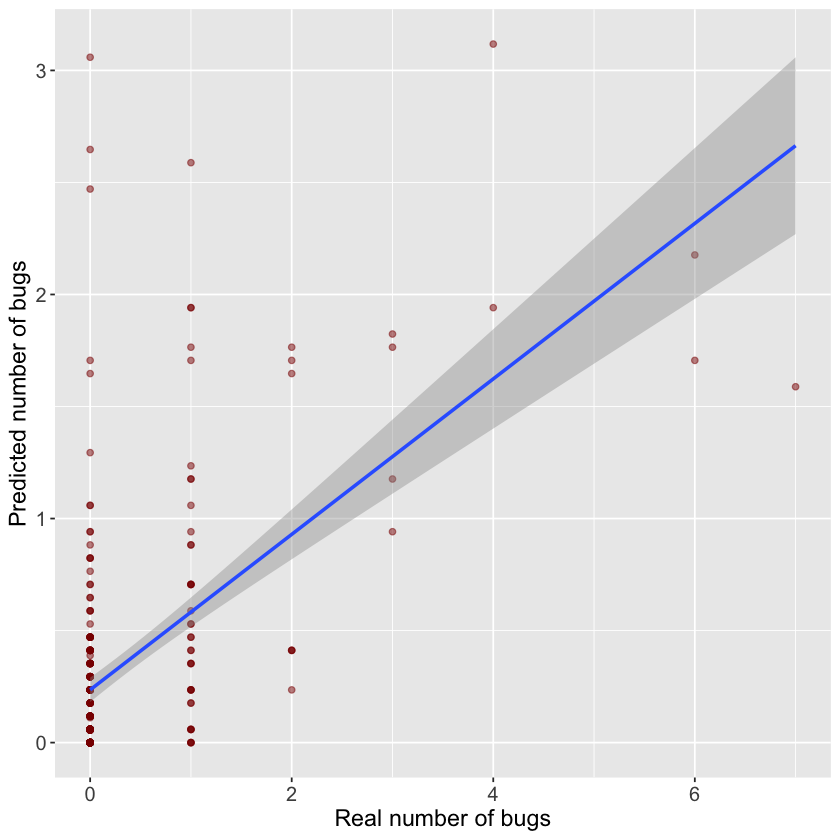

In [19]:
predictionChart(knnModel)

# kNN with Preprocessing

In [20]:
knnPreModel <- train(
  X_train, y_train,
  method = "knn",
  trControl = trcontrol,
  tuneGrid = knnGrid,
  preProcess = c("center", "scale")
)

In [21]:
knnPreModel

k-Nearest Neighbors 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   1  1.1110315  0.2337919  0.4312629
   3  0.9897522  0.2479433  0.4126622
   5  0.9182531  0.3010976  0.3985362
   7  0.8735214  0.3574528  0.3860900
   9  0.8546614  0.3764351  0.3887466
  11  0.8465719  0.3857048  0.3876368
  13  0.8512078  0.3906381  0.3905497
  15  0.8543840  0.3926405  0.3925642
  17  0.8631234  0.3868694  0.3960383
  19  0.8671264  0.3810937  0.3985816
  21  0.8715443  0.3816981  0.4002719
  23  0.8787554  0.3749737  0.4020283
  25  0.8866052  0.3672288  0.4043527

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 11.

In [22]:
knnPreModel$bestTune

,k
,<dbl>
6,11


In [23]:
knnPreStats <- evaluateStats(knnPreModel)
knnPreStats

$RMSE
[1] 0.746

$rSquare
[1] 0.271

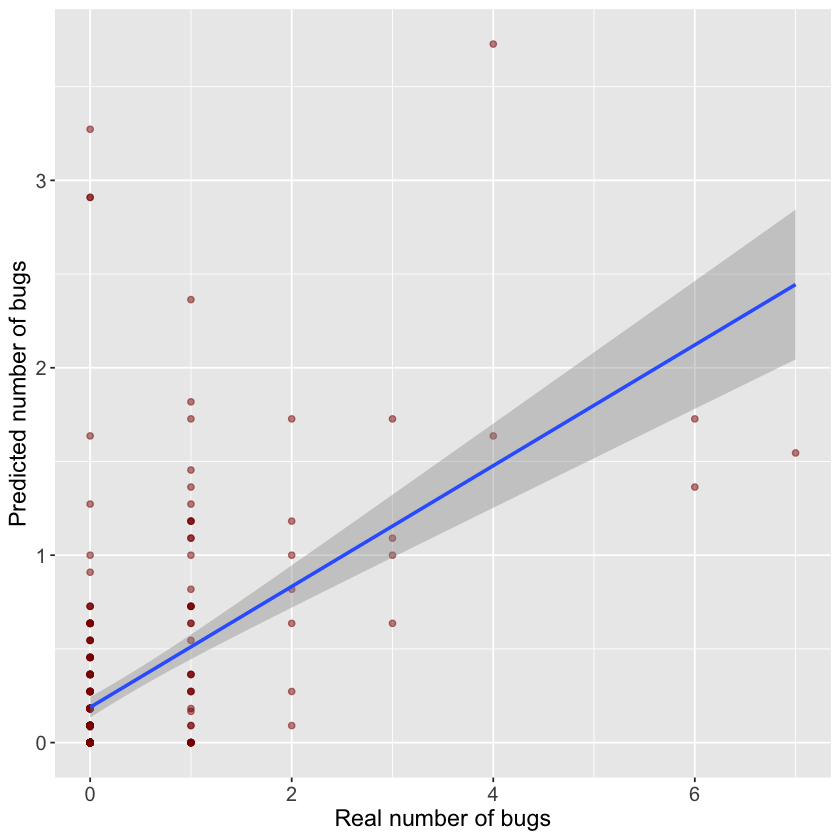

In [24]:
predictionChart(knnPreModel)

# Random Forest Regression

In [39]:
ncol(X_train)/3

[1] 4.333333

In [25]:
rfGrid <- expand.grid(.mtry=ncol(X_train)/3)

In [26]:
rfModel <- train(
  X_train, y_train,
  method = "rf",
  trControl = trcontrol,
  tuneGrid = rfGrid,
  importance = TRUE
)

In [27]:
rfModel

Random Forest 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 629, 628, 629, 628, 628, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8595395  0.4261077  0.4208862

Tuning parameter 'mtry' was held constant at a value of 4.333333

In [28]:
rfModel$bestTune

mtry
<dbl>
4.333333


In [30]:
rfStats <- evaluateStats(rfModel)
rfStats

$RMSE
[1] 0.752

$rSquare
[1] 0.259

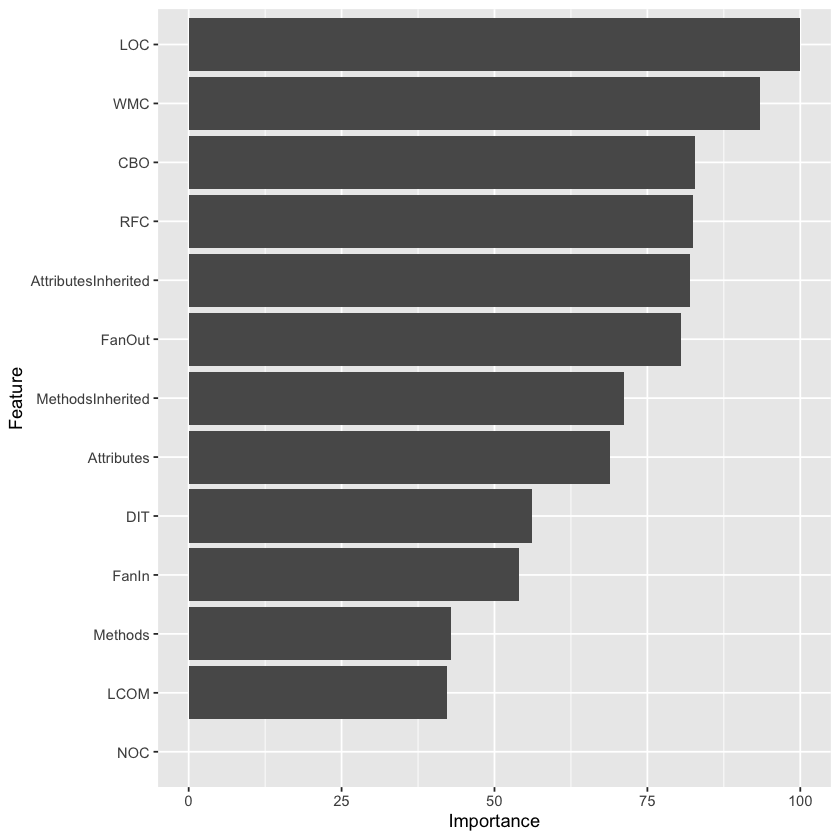

In [32]:
importancePlot(rfModel)

# Extreme Gradient Boosting regression

In [33]:
xgbGrid <- expand.grid(
    nrounds = c(100,200), 
    max_depth = c(10, 15, 20, 25),
    colsample_bytree = seq(0.5, 0.9, length.out = 5),
    eta = 0.1,
    gamma=0,
    min_child_weight = 1,
    subsample = 1
  )

In [34]:
xgbModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree"
)

In [35]:
xgbModel

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8898867  0.3775024  0.4270575
  10         0.5               200      0.8905914  0.3769755  0.4278259
  10         0.6               100      0.8969452  0.3681897  0.4221017
  10         0.6               200      0.8971113  0.3684032  0.4223535
  10         0.7               100      0.9124844  0.3503759  0.4244964
  10         0.7               200      0.9129505  0.3500249  0.4247938
  10         0.8               100      0.9181521  0.3512107  0.4213564
  10         0.8               200      0.9185492  0.3512472  0.4217109
  10         0.9               100      0.9520986  0.3204612  0.4284822
  10         0.9               200      0.9522027  0.3207756  0.4284628
  15         0.5 

In [36]:
xgbModel$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,100,20,0.1,0,0.5,1,1


In [37]:
xgbStats <- evaluateStats(xgbModel)
xgbStats

$RMSE
[1] 0.798

$rSquare
[1] 0.165

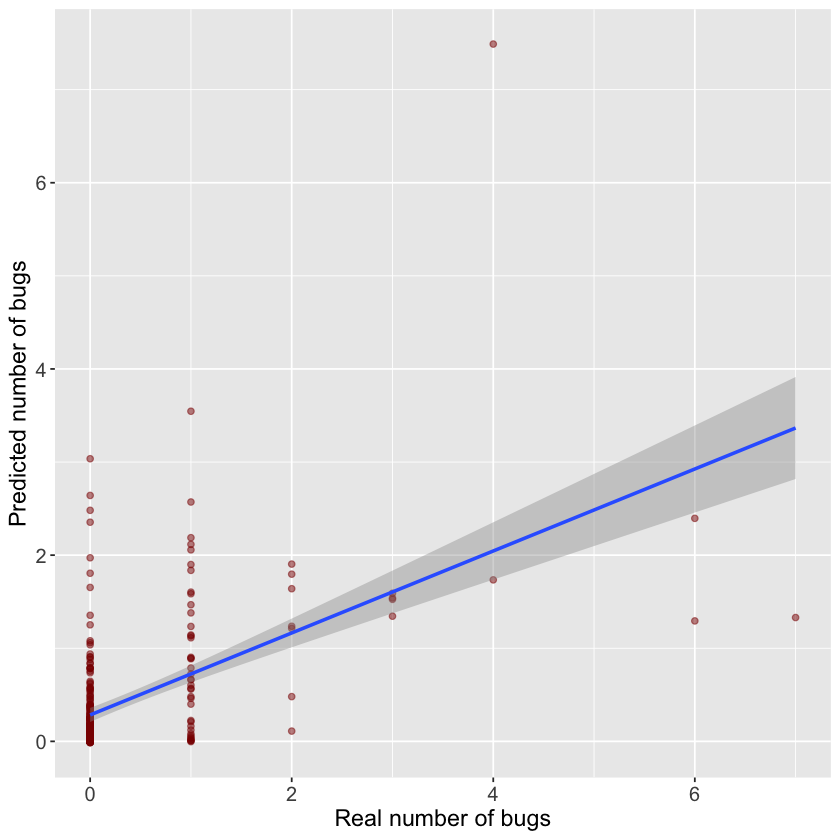

In [38]:
predictionChart(xgbModel)

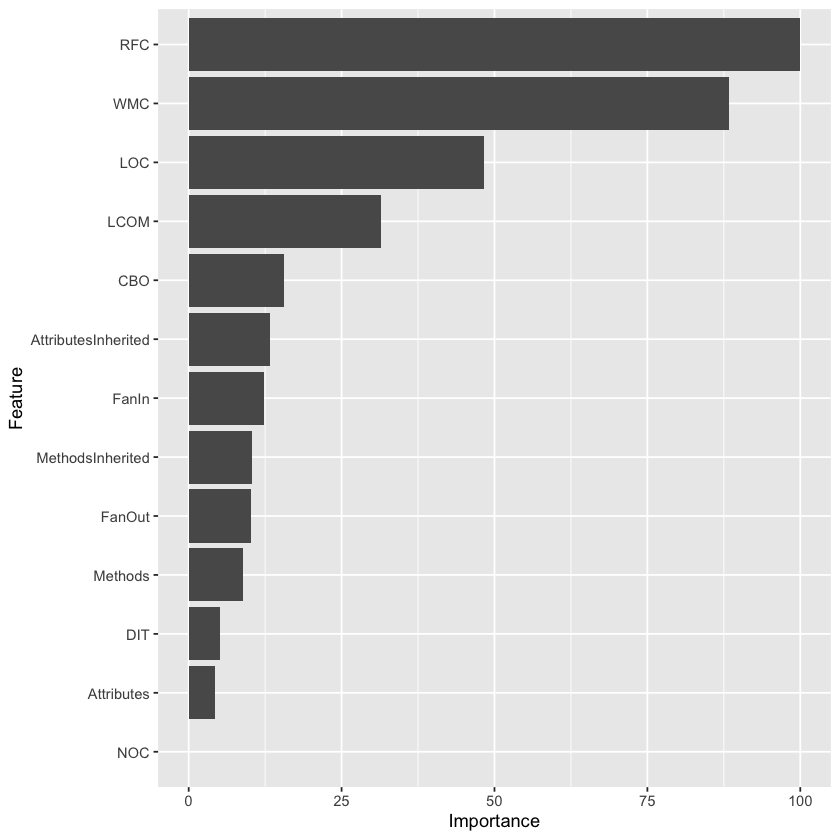

In [39]:
importancePlot(xgbModel)

In [40]:
xgbPreModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid = xgbGrid,
  method = "xgbTree",
  preProcess = c("center", "scale")
)

In [41]:
xgbPreModel

eXtreme Gradient Boosting 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 628, 629, 628, 628, 628, ... 
Resampling results across tuning parameters:

  max_depth  colsample_bytree  nrounds  RMSE       Rsquared   MAE      
  10         0.5               100      0.8377464  0.4242739  0.4046140
  10         0.5               200      0.8381507  0.4242313  0.4049667
  10         0.6               100      0.8793881  0.3774892  0.4175277
  10         0.6               200      0.8796041  0.3775956  0.4175385
  10         0.7               100      0.8891448  0.3679789  0.4166799
  10         0.7               200      0.8894802  0.3680964  0.4169136
  10         0.8               100      0.9466178  0.3496045  0.4249864
  10         0.8               200      0.9470641  0.3499382  0.4254958
  10         0.9               100      0.9364910  0.3302226  0.4309303
  10         0.9               200      0.9367627  0.3307362  0

In [43]:
xgbPreModel$bestTune

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,10,0.1,0,0.5,1,1


In [44]:
xgbPreStats <- evaluateStats(xgbPreModel)
xgbPreStats

$RMSE
[1] 0.796

$rSquare
[1] 0.169

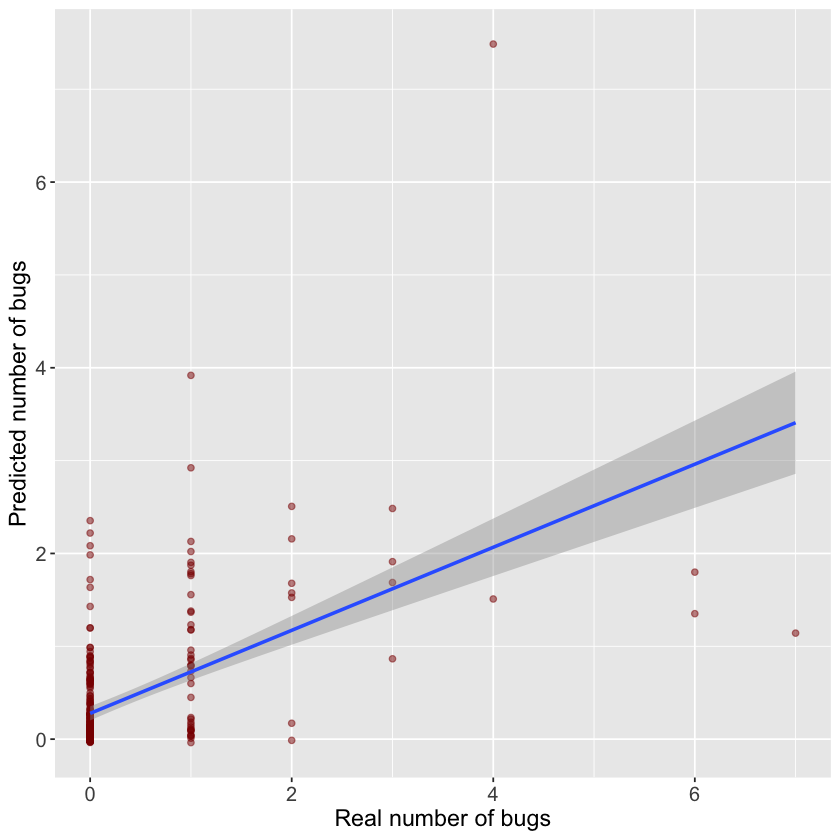

In [45]:
predictionChart(xgbPreModel)

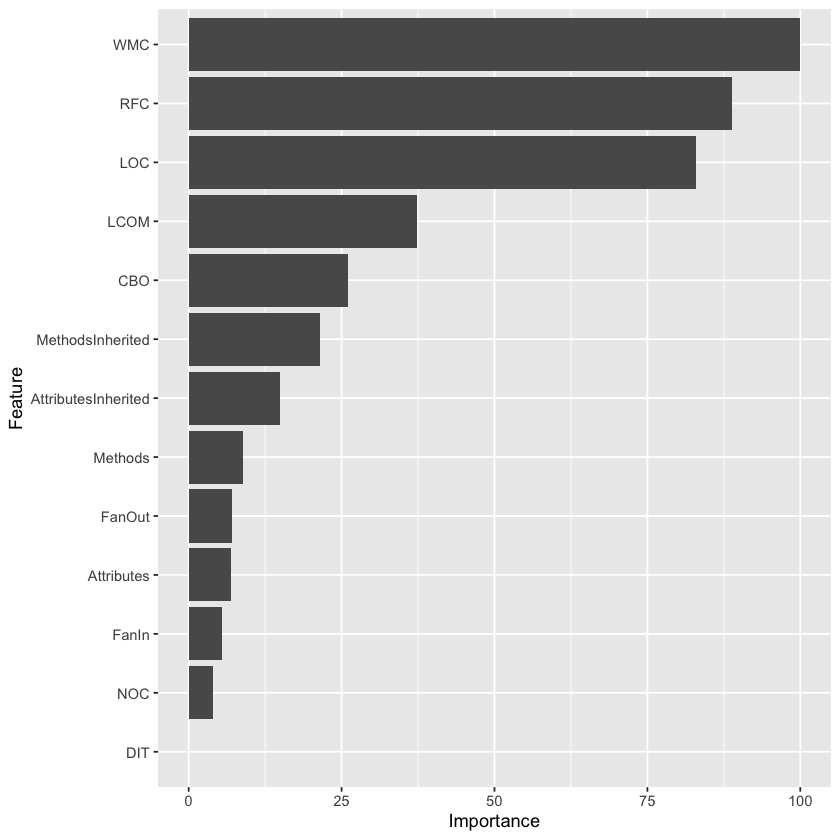

In [46]:
importancePlot(xgbPreModel)

# TODO Neural network regression

In [75]:
nnetGrid <-  expand.grid(size = seq(from = 1, to = 10, by = 1),
                        decay = seq(from = 0.1, to = 0.5, by = 0.1))

In [77]:
nnetModel <- train(
  X_train, y_train,
  trControl = trcontrol,
  tuneGrid= nnetGrid,
  method = "nnet",
  preProcess = c("center", "scale")
)

# weights:  16
initial  value 813.606476 
iter  10 value 692.463067
iter  20 value 667.918428
iter  30 value 659.068404
iter  40 value 658.328683
final  value 658.325292 
converged
# weights:  31
initial  value 819.202821 
iter  10 value 667.593260
iter  20 value 660.790109
iter  30 value 653.816949
iter  40 value 652.361832
iter  50 value 651.514248
iter  60 value 650.778237
iter  70 value 650.750103
final  value 650.749933 
converged
# weights:  46
initial  value 853.492091 
iter  10 value 689.971646
iter  20 value 660.374634
iter  30 value 653.977871
iter  40 value 651.459827
iter  50 value 646.360309
iter  60 value 643.252162
iter  70 value 642.929316
iter  80 value 642.766114
iter  90 value 642.273678
iter 100 value 642.216305
final  value 642.216305 
stopped after 100 iterations
# weights:  61
initial  value 810.139032 
iter  10 value 710.891329
iter  20 value 664.645412
iter  30 value 653.162656
iter  40 value 649.935467
iter  50 value 647.187315
iter  60 value 645.782872
iter  

initial  value 857.143660 
iter  10 value 672.877435
iter  20 value 660.140506
iter  30 value 658.212133
iter  40 value 657.777848
iter  50 value 657.339073
iter  60 value 657.252076
iter  70 value 657.232813
iter  80 value 657.230236
final  value 657.230192 
converged
# weights:  16
initial  value 868.035437 
iter  10 value 694.311416
iter  20 value 675.497256
iter  30 value 673.731769
final  value 673.694102 
converged
# weights:  31
initial  value 838.774744 
iter  10 value 706.148569
iter  20 value 681.796398
iter  30 value 668.803911
iter  40 value 667.454109
iter  50 value 667.319914
final  value 667.314928 
converged
# weights:  46
initial  value 848.080059 
iter  10 value 682.649060
iter  20 value 669.490974
iter  30 value 666.507776
iter  40 value 665.903318
iter  50 value 665.883885
final  value 665.883098 
converged
# weights:  61
initial  value 843.598374 
iter  10 value 686.937301
iter  20 value 666.904977
iter  30 value 665.155433
iter  40 value 664.367798
iter  50 value 

initial  value 751.429517 
iter  10 value 611.381735
iter  20 value 602.106519
iter  30 value 600.900894
final  value 600.900650 
converged
# weights:  31
initial  value 822.824689 
iter  10 value 625.214584
iter  20 value 604.495848
iter  30 value 598.834979
iter  40 value 595.999394
iter  50 value 595.699482
iter  60 value 595.608910
iter  70 value 595.606241
iter  80 value 595.605759
iter  80 value 595.605753
iter  80 value 595.605753
final  value 595.605753 
converged
# weights:  46
initial  value 747.923687 
iter  10 value 626.259088
iter  20 value 604.250675
iter  30 value 597.503024
iter  40 value 594.745760
iter  50 value 592.739080
iter  60 value 592.358849
iter  70 value 592.350771
final  value 592.350701 
converged
# weights:  61
initial  value 819.238435 
iter  10 value 640.883471
iter  20 value 600.359129
iter  30 value 591.444746
iter  40 value 589.806850
iter  50 value 589.472699
iter  60 value 588.984847
iter  70 value 588.910062
iter  80 value 588.906069
final  value 5

initial  value 744.321070 
iter  10 value 627.420260
iter  20 value 619.631547
iter  30 value 619.525556
final  value 619.525301 
converged
# weights:  31
initial  value 777.066754 
iter  10 value 630.788575
iter  20 value 616.572595
iter  30 value 612.313505
iter  40 value 611.744877
iter  50 value 611.733504
final  value 611.733473 
converged
# weights:  46
initial  value 762.699248 
iter  10 value 622.863538
iter  20 value 608.634383
iter  30 value 607.473084
iter  40 value 607.413727
iter  50 value 607.330990
iter  60 value 607.290588
final  value 607.290390 
converged
# weights:  61
initial  value 752.051839 
iter  10 value 630.068705
iter  20 value 609.554147
iter  30 value 607.063337
iter  40 value 606.081648
iter  50 value 605.651864
iter  60 value 605.603242
iter  70 value 605.525322
iter  80 value 605.460037
final  value 605.459361 
converged
# weights:  76
initial  value 797.602626 
iter  10 value 621.024572
iter  20 value 606.733949
iter  30 value 605.917952
iter  40 value 

initial  value 800.246949 
iter  10 value 604.815671
iter  20 value 592.635557
iter  30 value 588.513868
iter  40 value 585.080241
iter  50 value 584.332925
iter  60 value 584.093103
iter  70 value 583.986411
iter  80 value 583.870442
iter  90 value 583.750379
iter 100 value 583.690535
final  value 583.690535 
stopped after 100 iterations
# weights:  16
initial  value 736.546019 
iter  10 value 621.794060
iter  20 value 609.348972
iter  30 value 608.828914
iter  40 value 608.536497
iter  50 value 608.467250
final  value 608.467161 
converged
# weights:  31
initial  value 773.322830 
iter  10 value 624.563205
iter  20 value 607.217042
iter  30 value 600.310113
iter  40 value 599.451505
iter  50 value 599.224815
iter  60 value 599.186433
final  value 599.186258 
converged
# weights:  46
initial  value 783.594215 
iter  10 value 610.318999
iter  20 value 598.311989
iter  30 value 597.464273
iter  40 value 597.202430
iter  50 value 597.186077
final  value 597.186057 
converged
# weights:  

initial  value 809.456214 
iter  10 value 669.388300
iter  20 value 658.063658
iter  30 value 651.484996
iter  40 value 646.151251
iter  50 value 645.233270
final  value 645.218561 
converged
# weights:  46
initial  value 817.758487 
iter  10 value 709.543235
iter  20 value 663.925349
iter  30 value 654.987696
iter  40 value 651.061466
iter  50 value 650.390062
iter  60 value 650.274906
iter  70 value 650.170995
iter  80 value 650.107274
iter  90 value 650.076346
iter 100 value 650.074708
final  value 650.074708 
stopped after 100 iterations
# weights:  61
initial  value 868.821354 
iter  10 value 664.422015
iter  20 value 647.014468
iter  30 value 643.092653
iter  40 value 642.014324
iter  50 value 641.850285
iter  60 value 641.658423
iter  70 value 641.591064
iter  80 value 641.586570
iter  90 value 641.586285
final  value 641.586259 
converged
# weights:  76
initial  value 794.518668 
iter  10 value 694.113984
iter  20 value 664.738306
iter  30 value 656.137187
iter  40 value 653.81

initial  value 834.987915 
iter  10 value 670.748038
iter  20 value 664.097641
iter  30 value 662.629030
iter  40 value 662.370484
iter  50 value 662.351866
iter  60 value 662.119705
iter  70 value 661.871819
iter  80 value 661.827779
iter  90 value 661.805376
iter 100 value 661.774270
final  value 661.774270 
stopped after 100 iterations
# weights:  151
initial  value 891.792087 
iter  10 value 694.886460
iter  20 value 664.451399
iter  30 value 662.624835
iter  40 value 660.855260
iter  50 value 660.127810
iter  60 value 659.990044
iter  70 value 659.924791
iter  80 value 659.882751
iter  90 value 659.878361
iter 100 value 659.877839
final  value 659.877839 
stopped after 100 iterations
# weights:  16
initial  value 835.332476 
iter  10 value 692.776414
iter  20 value 681.227342
iter  30 value 676.702450
final  value 676.696571 
converged
# weights:  31
initial  value 834.966182 
iter  10 value 700.123058
iter  20 value 676.494034
iter  30 value 670.286959
iter  40 value 669.565769
i

initial  value 882.545890 
iter  10 value 672.347868
iter  20 value 652.958961
iter  30 value 646.636419
iter  40 value 645.042877
iter  50 value 643.000022
iter  60 value 642.113834
iter  70 value 641.365418
iter  80 value 641.120475
iter  90 value 641.032382
iter 100 value 641.017008
final  value 641.017008 
stopped after 100 iterations
# weights:  151
initial  value 866.401905 
iter  10 value 666.560309
iter  20 value 652.704992
iter  30 value 647.022658
iter  40 value 644.045360
iter  50 value 642.636856
iter  60 value 641.564639
iter  70 value 641.080780
iter  80 value 640.515826
iter  90 value 640.146479
iter 100 value 639.878089
final  value 639.878089 
stopped after 100 iterations
# weights:  16
initial  value 834.018309 
iter  10 value 704.051604
iter  20 value 686.714911
iter  30 value 677.254754
iter  40 value 676.688414
iter  50 value 676.565937
iter  60 value 676.441375
final  value 676.384242 
converged
# weights:  31
initial  value 845.041092 
iter  10 value 680.386721
i

initial  value 813.451680 
iter  10 value 688.846361
iter  20 value 673.019709
iter  30 value 672.403344
iter  40 value 672.041237
iter  50 value 671.888393
iter  60 value 671.797157
iter  70 value 671.782205
final  value 671.781796 
converged
# weights:  136
initial  value 831.967308 
iter  10 value 680.840643
iter  20 value 674.652272
iter  30 value 671.458233
iter  40 value 670.657716
iter  50 value 670.392841
iter  60 value 670.351648
iter  70 value 670.327798
iter  80 value 670.324677
iter  90 value 670.324383
iter  90 value 670.324377
iter  90 value 670.324377
final  value 670.324377 
converged
# weights:  151
initial  value 832.945198 
iter  10 value 681.068947
iter  20 value 673.314277
iter  30 value 672.144180
iter  40 value 670.711132
iter  50 value 670.451549
iter  60 value 670.364680
iter  70 value 670.339448
iter  80 value 670.335648
final  value 670.335270 
converged
# weights:  16
initial  value 825.133216 
iter  10 value 693.815670
iter  20 value 691.746406
final  value

initial  value 727.786381 
iter  10 value 639.545429
iter  20 value 485.830355
iter  30 value 467.745886
iter  40 value 459.999317
iter  50 value 457.802523
iter  60 value 457.287221
iter  70 value 457.048405
iter  80 value 456.953828
iter  90 value 456.860828
iter 100 value 456.844263
final  value 456.844263 
stopped after 100 iterations
# weights:  136
initial  value 615.519498 
iter  10 value 468.843966
iter  20 value 460.955973
iter  30 value 457.216672
iter  40 value 456.295825
iter  50 value 456.041892
iter  60 value 455.964356
iter  70 value 455.915841
iter  80 value 455.901387
iter  90 value 455.898773
iter 100 value 455.898058
final  value 455.898058 
stopped after 100 iterations
# weights:  151
initial  value 623.040396 
iter  10 value 491.409982
iter  20 value 465.676418
iter  30 value 458.717116
iter  40 value 457.144197
iter  50 value 456.743554
iter  60 value 456.654167
iter  70 value 456.635023
iter  80 value 456.619439
iter  90 value 456.612276
final  value 456.612113 


initial  value 805.473764 
iter  10 value 663.633601
iter  20 value 655.518077
iter  30 value 645.657057
iter  40 value 643.905363
iter  50 value 643.675807
final  value 643.675663 
converged
# weights:  31
initial  value 822.624112 
iter  10 value 663.336260
iter  20 value 646.391307
iter  30 value 643.814682
iter  40 value 643.027260
iter  50 value 642.538263
iter  60 value 642.520861
final  value 642.520674 
converged
# weights:  46
initial  value 835.859906 
iter  10 value 662.285771
iter  20 value 643.870795
iter  30 value 640.237670
iter  40 value 637.841631
iter  50 value 637.207239
iter  60 value 637.003393
iter  70 value 636.326912
iter  80 value 634.727647
iter  90 value 629.799054
iter 100 value 629.084068
final  value 629.084068 
stopped after 100 iterations
# weights:  61
initial  value 818.250274 
iter  10 value 666.805733
iter  20 value 653.141568
iter  30 value 639.593379
iter  40 value 631.735557
iter  50 value 628.395461
iter  60 value 627.576572
iter  70 value 627.44

initial  value 833.889531 
iter  10 value 655.421086
iter  20 value 649.606381
iter  30 value 648.258401
iter  40 value 647.592062
iter  50 value 647.508602
iter  60 value 647.371975
iter  70 value 647.293439
iter  80 value 647.236065
iter  90 value 647.176897
iter 100 value 647.165694
final  value 647.165694 
stopped after 100 iterations
# weights:  151
initial  value 820.789709 
iter  10 value 653.195576
iter  20 value 648.532792
iter  30 value 647.960374
iter  40 value 647.834114
iter  50 value 647.815154
iter  60 value 647.811884
iter  70 value 647.809011
final  value 647.808941 
converged
# weights:  16
initial  value 813.996907 
iter  10 value 670.744756
iter  20 value 662.922173
iter  30 value 662.848449
final  value 662.848434 
converged
# weights:  31
initial  value 810.299393 
iter  10 value 669.765422
iter  20 value 657.559049
iter  30 value 656.011639
iter  40 value 655.963518
final  value 655.963413 
converged
# weights:  46
initial  value 810.996944 
iter  10 value 666.25

initial  value 672.393715 
iter  10 value 576.115940
iter  20 value 565.073305
iter  30 value 564.958401
iter  40 value 564.616748
iter  50 value 564.556564
iter  50 value 564.556563
iter  50 value 564.556563
final  value 564.556563 
converged
# weights:  31
initial  value 674.988024 
iter  10 value 566.302141
iter  20 value 559.081542
iter  30 value 557.886961
iter  40 value 557.365376
iter  50 value 557.309226
iter  60 value 557.286636
iter  60 value 557.286634
iter  60 value 557.286634
final  value 557.286634 
converged
# weights:  46
initial  value 720.819830 
iter  10 value 564.220434
iter  20 value 557.501209
iter  30 value 555.790997
iter  40 value 555.618656
iter  50 value 555.577867
final  value 555.577852 
converged
# weights:  61
initial  value 704.404783 
iter  10 value 577.733622
iter  20 value 560.111372
iter  30 value 555.691251
iter  40 value 553.749244
iter  50 value 553.536086
iter  60 value 553.474736
iter  70 value 552.608473
iter  80 value 549.327436
iter  90 value

initial  value 688.867984 
iter  10 value 572.150837
iter  20 value 569.563029
iter  30 value 569.405627
final  value 569.405595 
converged
# weights:  46
initial  value 717.627799 
iter  10 value 622.230141
iter  20 value 578.443644
iter  30 value 574.998337
iter  40 value 574.381480
iter  50 value 574.225833
iter  60 value 574.199109
final  value 574.199048 
converged
# weights:  61
initial  value 745.900315 
iter  10 value 592.261688
iter  20 value 568.336395
iter  30 value 566.880682
iter  40 value 566.856322
final  value 566.856242 
converged
# weights:  76
initial  value 718.193855 
iter  10 value 576.886027
iter  20 value 569.008764
iter  30 value 565.962907
iter  40 value 565.626212
iter  50 value 565.548795
iter  60 value 565.546798
final  value 565.546784 
converged
# weights:  91
initial  value 783.083040 
iter  10 value 582.600621
iter  20 value 567.486797
iter  30 value 565.423446
iter  40 value 565.173945
iter  50 value 565.091405
iter  60 value 565.076873
final  value 56

initial  value 807.109375 
iter  10 value 683.900003
iter  20 value 657.451291
iter  30 value 656.080093
iter  40 value 655.955640
final  value 655.953783 
converged
# weights:  46
initial  value 791.940280 
iter  10 value 673.776477
iter  20 value 652.459135
iter  30 value 650.247765
iter  40 value 648.996255
iter  50 value 648.930161
final  value 648.929914 
converged
# weights:  61
initial  value 821.684128 
iter  10 value 664.268581
iter  20 value 649.420971
iter  30 value 648.854438
iter  40 value 648.219419
iter  50 value 648.010879
iter  60 value 647.954462
iter  70 value 647.943356
final  value 647.941486 
converged
# weights:  76
initial  value 841.560690 
iter  10 value 657.705164
iter  20 value 649.397409
iter  30 value 647.869578
iter  40 value 647.672613
iter  50 value 647.563890
iter  60 value 647.523930
iter  70 value 647.520592
iter  70 value 647.520588
iter  70 value 647.520588
final  value 647.520588 
converged
# weights:  91
initial  value 828.360763 
iter  10 value 

initial  value 827.473120 
iter  10 value 654.144644
iter  20 value 643.701332
iter  30 value 641.576651
iter  40 value 639.613902
iter  50 value 638.386668
iter  60 value 637.975587
iter  70 value 635.836073
iter  80 value 632.241762
iter  90 value 631.146070
iter 100 value 629.490901
final  value 629.490901 
stopped after 100 iterations
# weights:  91
initial  value 786.813123 
iter  10 value 670.664904
iter  20 value 649.955058
iter  30 value 634.192097
iter  40 value 629.365785
iter  50 value 628.337591
iter  60 value 627.956627
iter  70 value 627.901990
iter  80 value 627.896995
final  value 627.896830 
converged
# weights:  106
initial  value 834.463456 
iter  10 value 696.190918
iter  20 value 650.755669
iter  30 value 635.794831
iter  40 value 631.349828
iter  50 value 629.027663
iter  60 value 628.527058
iter  70 value 628.084342
iter  80 value 627.207316
iter  90 value 626.496225
iter 100 value 625.855349
final  value 625.855349 
stopped after 100 iterations
# weights:  121
i

initial  value 834.678219 
iter  10 value 684.935100
iter  20 value 667.006727
iter  30 value 665.900832
iter  40 value 665.452641
iter  50 value 665.405600
iter  60 value 665.397530
final  value 665.397516 
converged
# weights:  61
initial  value 882.664836 
iter  10 value 668.816399
iter  20 value 661.390438
iter  30 value 658.780443
iter  40 value 658.157889
iter  50 value 658.052122
iter  60 value 658.046875
final  value 658.046239 
converged
# weights:  76
initial  value 822.066891 
iter  10 value 668.230372
iter  20 value 659.277182
iter  30 value 657.966709
iter  40 value 657.646196
iter  50 value 657.609518
iter  60 value 657.529800
iter  70 value 657.296063
iter  80 value 657.287246
iter  90 value 657.282913
iter 100 value 657.276667
final  value 657.276667 
stopped after 100 iterations
# weights:  91
initial  value 834.480835 
iter  10 value 681.171489
iter  20 value 659.162892
iter  30 value 656.938659
iter  40 value 656.844916
iter  50 value 656.818469
iter  60 value 656.81

In [78]:
nnetModel

Neural Network 

Pre-processing: centered (13), scaled (13) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 628, 629, 628, 628, 628, 628, ... 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared   MAE      
   1    0.1    0.9264948  0.2382731  0.4524546
   1    0.2    0.9249336  0.2560423  0.4595475
   1    0.3    0.9251073  0.2555224  0.4653827
   1    0.4    0.9270616  0.2474113  0.4745519
   1    0.5    0.9294045  0.2417177  0.4778157
   2    0.1    0.9238804  0.2541961  0.4305819
   2    0.2    0.9272823  0.2414453  0.4524316
   2    0.3    0.9242500  0.2507754  0.4614330
   2    0.4    0.9242242  0.2530832  0.4624460
   2    0.5    0.9278767  0.2432071  0.4682038
   3    0.1    0.9159338  0.2822261  0.4288607
   3    0.2    0.9179098  0.2682109  0.4475585
   3    0.3    0.9204593  0.2592954  0.4525380
   3    0.4    0.9254130  0.2508890  0.4585164
   3    0.5    0.9250188  0.2563788  0.4625399
   4    0.1    0.9219791  0.2604586  0.424

In [79]:
nnetModel$bestTune

,size,decay
,<dbl>,<dbl>
27,6,0.2


In [81]:
nnetModelStats <- evaluateStats(nnetModel)
nnetModelStats

$RMSE
[1] 0.746

$rSquare
[1] 0.271

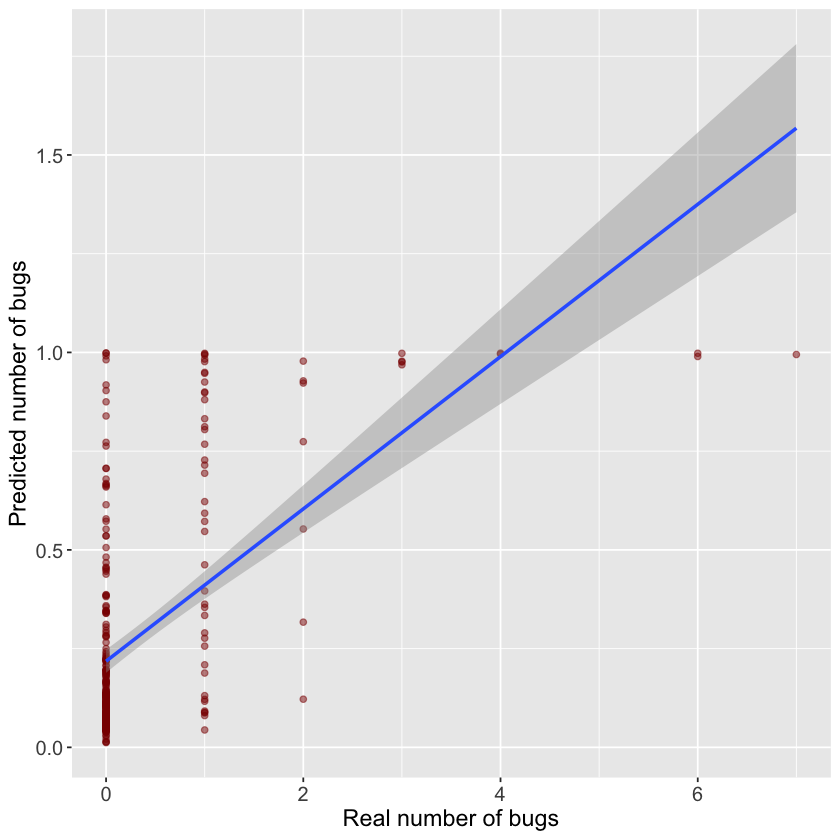

In [82]:
predictionChart(nnetModel)

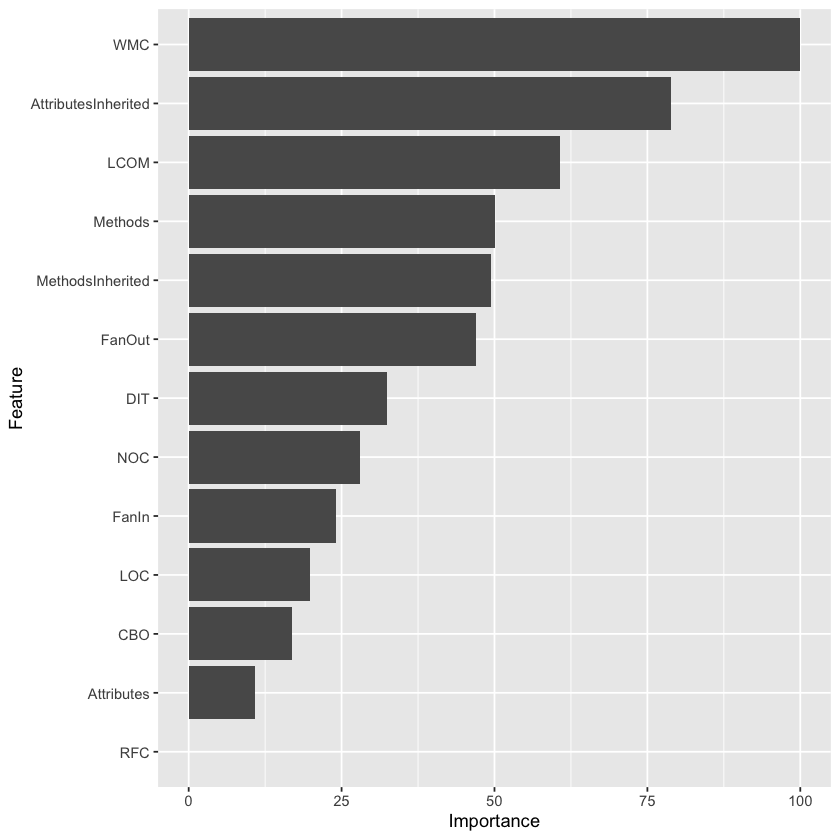

In [83]:
importancePlot(nnetModel)

In [107]:
maxs <- apply(bugsData, 2, max) 
mins <- apply(bugsData, 2, min)
scaled <- as.data.frame(scale(bugsData, center = mins, scale = maxs - mins))
train_ <- scaled[inTrain,]
test_ <- scaled[-inTrain,]

In [136]:
n <- names(train_)
formula <- as.formula(paste("Bugs ~", paste(n[!n %in% "Bugs"], collapse = " + ")))
nnetModel <- neuralnet(formula,data=train_,hidden=c(6,3), algorithm="rprop+", linear.output=TRUE)

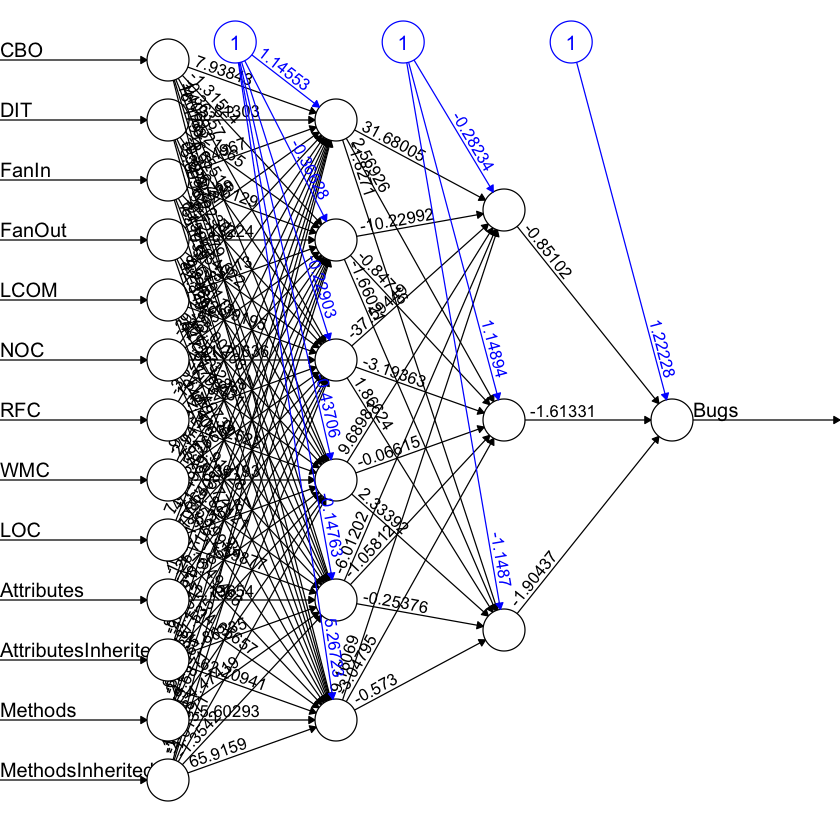

In [137]:
plot(nn, rep="best")

In [139]:
nnetModelStats <- evaluateStats(nn)
nnetModelStats

$RMSE
[1] 0.928

$rSquare
[1] -0.128

To be continued... Just some experiments.

# TODO Compare different regression models

In [1]:
compareDf <- data.frame(t(data.frame(
  knn = unlist(knnStats),
  knnPre = unlist(knnPreStats),
  rf = unlist(rfStats),
  xgb = unlist(xgbStats),
  xgbPre = unlist(xgbPreStats),
    nnet = unlist(nnetModelStats)
)))
compareDf

ERROR: Error in unlist(knnStats): nie znaleziono obiektu 'knnStats'


To be continued...